In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
import seaborn as sb
import cv2
import os

from torch import optim
from torch import nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.autograd import Variable
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from fractions import Fraction
import time
import help

F:\Python\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


此项目期望目标为$\color{red}{kaggle  10\%}$，即$\color{blue}{LogLoss}$达到$\color{red}{0.006}$以内

In [2]:
#Hyper parameters
EPOCHS = 15
DROPOUT = 0.5


## 使用ImageNet上的预训练模型VGG16作为基础模型进行训练

In [3]:
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [4]:

for param in model_vgg16.parameters():
    param.requires_grad = False
    
#分类器在Vgg16基础上修改，输出output_size为种类2
vgg16_classifier = nn.Sequential(nn.Linear(25088, 4096),
                           nn.ReLU(),
                           nn.Dropout(p=DROPOUT),
                           nn.Linear(4096, 4096),
                           nn.ReLU(),
                           nn.Dropout(p=DROPOUT),
                           nn.Linear(4096, 2),
                           nn.LogSoftmax(dim=1))
model_vgg16.classifier = vgg16_classifier

In [3]:
#损失函数
criterion = nn.NLLLoss()

In [4]:
#新建Dataframe用以存放训练过程中的loss
model_indicators = pd.DataFrame(columns=['point','train_loss','val_loss'])

In [5]:
def do_deep_learning(model,model_name,train_dataloaders,valid_dataloaders,epochs,print_every,criterion,checkpoint_path,device='cpu'):
    '''
        model:创建的模型
        model_name:模型名称，便于保存模型时选择保存的方法
        train_dataloaders:训练集
        epochs:训练次数
        print_every:训练每隔多少次打印一次结果
        criterion:误差函数
        checkpoint_path:模型保存的地址
        device:训练使用的是cpu还是GPU
    
    '''
    
    epochs = epochs
    print_every = print_every
    steps = 0
    n_epochs_stop = 10
    min_val_loss = np.Inf
    epochs_no_improve = 0
    point = 0
    
    model.to(device)
    
    for e in range(epochs):
        model.train()
        running_loss = 0
        if model_name == 'resnet50':
            optimizer = optim.Adam(model.fc.parameters(),lr=help.dynamic_learning_rate(e,1))
        elif model_name == 'inception_v3':
            optimizer = optim.Adam(model.fc.parameters(),lr=help.dynamic_learning_rate(e,10))
        else:
            optimizer = optim.Adam(model.classifier.parameters(),lr=help.dynamic_learning_rate(e,1))
        for ii,(images,labels) in enumerate(train_dataloaders):
            steps += 1
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()
            
            outputs = model.forward(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                point += 1
                accuracy = 0
                val_loss = 0
                with torch.no_grad():
                    model.eval()
                    for ii,(images,labels) in enumerate(valid_dataloaders):
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        val_loss += criterion(outputs,labels).item()
                        
                        ps = torch.exp(outputs).data
                        equality = (labels.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean() 
                
                print('Epochs: {}/{}...'.format(e+1,epochs),
                     'Trianing Loss:{:.3f}...'.format(running_loss/print_every),
                     'Val Loss:{:.3f}...'.format(val_loss/len(valid_dataloaders)),
                     'Val Accuracy:{:.3f}'.format(accuracy/len(valid_dataloaders)))
                
                model_indicators.loc[model_indicators.shape[0]] = [point,running_loss/print_every,val_loss/len(valid_dataloaders)]
                #早期停止,根据模型训练过程中在验证集上的损失来保存表现最好的模型
                if val_loss < min_val_loss:
                    if model_name == 'resnet50' or model_name == 'inception_v3':
                        help.fc_save_checkpoint(epochs,optimizer,model,checkpoint_path)
                    else:
                        help.save_checkpoint(epochs,optimizer,model,checkpoint_path)
                    epochs_no_improve = 0
                    min_val_loss = val_loss
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == n_epochs_stop:
                        print('Early stopping!')
                
                running_loss = 0
                model.train()
                

In [8]:
start = time.time()
do_deep_learning(model_vgg16,'vgg16',help.train_dataloaders,help.valid_dataloaders,EPOCHS,help.print_every,criterion,help.vgg16_checkpoint_path,help.device)
end = time.time()
runing_time = end - start
print('Vgg16 Training time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

Epochs: 1/15... Trianing Loss:0.197... Val Loss:0.036... Val Accuracy:0.986
Epochs: 1/15... Trianing Loss:0.168... Val Loss:0.039... Val Accuracy:0.985
Epochs: 1/15... Trianing Loss:0.169... Val Loss:0.045... Val Accuracy:0.979
Epochs: 2/15... Trianing Loss:0.129... Val Loss:0.051... Val Accuracy:0.977
Epochs: 2/15... Trianing Loss:0.138... Val Loss:0.034... Val Accuracy:0.986
Epochs: 2/15... Trianing Loss:0.152... Val Loss:0.032... Val Accuracy:0.988
Epochs: 3/15... Trianing Loss:0.094... Val Loss:0.030... Val Accuracy:0.987
Epochs: 3/15... Trianing Loss:0.132... Val Loss:0.030... Val Accuracy:0.990
Epochs: 3/15... Trianing Loss:0.138... Val Loss:0.030... Val Accuracy:0.988
Epochs: 4/15... Trianing Loss:0.076... Val Loss:0.029... Val Accuracy:0.991
Epochs: 4/15... Trianing Loss:0.126... Val Loss:0.035... Val Accuracy:0.988
Epochs: 4/15... Trianing Loss:0.137... Val Loss:0.032... Val Accuracy:0.988
Epochs: 5/15... Trianing Loss:0.051... Val Loss:0.032... Val Accuracy:0.989
Epochs: 5/15

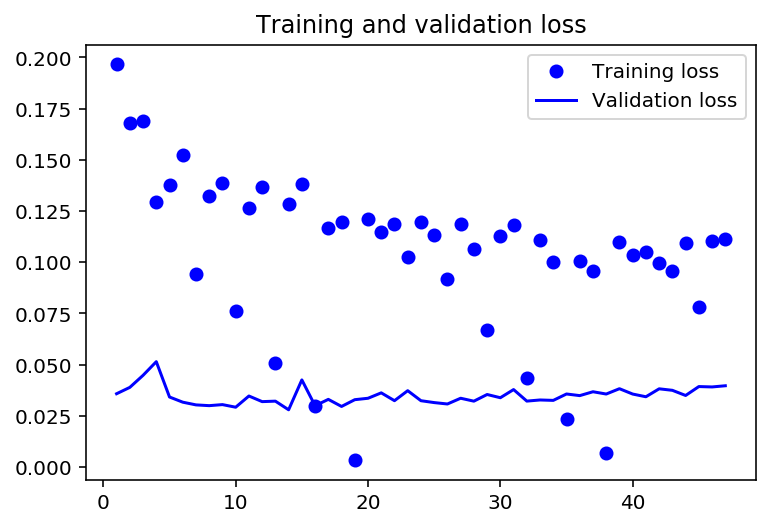

In [9]:
model_indicators_vgg16 = model_indicators.copy()
#画Train Loss与Val Loss的走向图
help.plt_result(model_indicators_vgg16)

In [10]:
loadmodel_vgg16 = help.load_checkpoint(help.vgg16_checkpoint_path,'vgg16')
help.check_logloss_on_test(loadmodel_vgg16,help.datatest_dataloaders,criterion,help.device)

Test Loss:0.026... Test Accuracy:0.990


VGG16模型在测试集上的Test loss达到0.026，满足逾期低于0.06，随后将用该模型测试kaggle测试集，提交结果看最终得分

## 使用ImageNet上的预训练模型Densenet121作为基础模型进行训练

In [12]:
model_densenet121 = models.densenet121(pretrained=True)
model_densenet121.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [13]:
for param in model_densenet121.parameters():
    param.requires_grad = False
    
#分类器在densenet121基础上修改，输出output_size为种类2
densenet121_classifier = nn.Sequential(
                           nn.Linear(1024, 2),
                           nn.LogSoftmax(dim=1))
model_densenet121.classifier = densenet121_classifier
print(model_densenet121.classifier)

Sequential(
  (0): Linear(in_features=1024, out_features=2, bias=True)
  (1): LogSoftmax()
)


In [14]:
model_indicators.drop(model_indicators.index,inplace=True)
start = time.time()
do_deep_learning(model_densenet121,'densenet121',help.train_dataloaders,help.valid_dataloaders,EPOCHS,help.print_every,criterion,help.densenet121_checkpoint_path,help.device)
end = time.time()
runing_time = end - start
print('Densenet121 Training time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

Epochs: 1/15... Trianing Loss:0.554... Val Loss:0.364... Val Accuracy:0.942
Epochs: 1/15... Trianing Loss:0.363... Val Loss:0.232... Val Accuracy:0.967
Epochs: 1/15... Trianing Loss:0.292... Val Loss:0.175... Val Accuracy:0.970
Epochs: 2/15... Trianing Loss:0.202... Val Loss:0.133... Val Accuracy:0.975
Epochs: 2/15... Trianing Loss:0.226... Val Loss:0.110... Val Accuracy:0.977
Epochs: 2/15... Trianing Loss:0.205... Val Loss:0.099... Val Accuracy:0.978
Epochs: 3/15... Trianing Loss:0.133... Val Loss:0.087... Val Accuracy:0.983
Epochs: 3/15... Trianing Loss:0.180... Val Loss:0.083... Val Accuracy:0.978
Epochs: 3/15... Trianing Loss:0.186... Val Loss:0.076... Val Accuracy:0.980
Epochs: 4/15... Trianing Loss:0.086... Val Loss:0.071... Val Accuracy:0.983
Epochs: 4/15... Trianing Loss:0.170... Val Loss:0.067... Val Accuracy:0.982
Epochs: 4/15... Trianing Loss:0.167... Val Loss:0.064... Val Accuracy:0.983
Epochs: 5/15... Trianing Loss:0.057... Val Loss:0.061... Val Accuracy:0.983
Epochs: 5/15

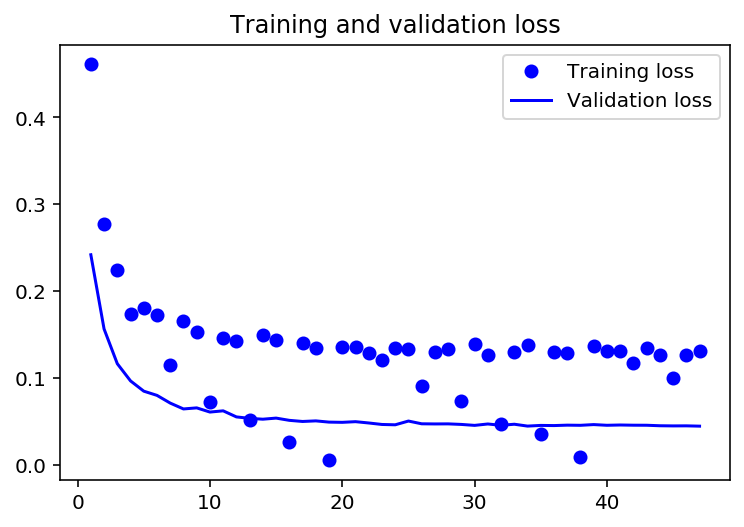

In [22]:
model_indicators_densenet121 = model_indicators.copy()
help.plt_result(model_indicators_densenet121)

In [16]:
loadmodel_densenet121 = help.load_checkpoint(help.densenet121_checkpoint_path,'densenet121')
help.check_logloss_on_test(loadmodel_densenet121,help.datatest_dataloaders,criterion,help.device)

Test Loss:0.046... Test Accuracy:0.987


Densenet121模型在测试集上的Test loss达到0.046，满足逾期低于0.06，随后将用该模型测试kaggle测试集，提交结果看最终得分

## 使用ImageNet上的预训练模型Resnet50作为基础模型进行训练

In [18]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [19]:
for param in model_resnet50.parameters():
    param.requires_grad = False
    
#分类器在resnet50基础上修改，输出output_size为种类2
resnet50_fc = nn.Sequential(
                           nn.Linear(2048, 2),
                           nn.LogSoftmax(dim=1))
model_resnet50.fc = resnet50_fc
print(model_resnet50.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=2, bias=True)
  (1): LogSoftmax()
)


In [20]:
model_indicators.drop(model_indicators.index,inplace=True)
start = time.time()
do_deep_learning(model_resnet50,'resnet50',help.train_dataloaders,help.valid_dataloaders,EPOCHS,help.print_every,criterion,help.resnet50_checkpoint_path,help.device)
end = time.time()
runing_time = end - start
print('Resnet50 Training time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

Epochs: 1/15... Trianing Loss:0.461... Val Loss:0.242... Val Accuracy:0.972
Epochs: 1/15... Trianing Loss:0.277... Val Loss:0.157... Val Accuracy:0.976
Epochs: 1/15... Trianing Loss:0.224... Val Loss:0.117... Val Accuracy:0.979
Epochs: 2/15... Trianing Loss:0.174... Val Loss:0.097... Val Accuracy:0.979
Epochs: 2/15... Trianing Loss:0.181... Val Loss:0.085... Val Accuracy:0.978
Epochs: 2/15... Trianing Loss:0.172... Val Loss:0.080... Val Accuracy:0.977
Epochs: 3/15... Trianing Loss:0.115... Val Loss:0.071... Val Accuracy:0.983
Epochs: 3/15... Trianing Loss:0.166... Val Loss:0.064... Val Accuracy:0.983
Epochs: 3/15... Trianing Loss:0.153... Val Loss:0.066... Val Accuracy:0.981
Epochs: 4/15... Trianing Loss:0.073... Val Loss:0.061... Val Accuracy:0.982
Epochs: 4/15... Trianing Loss:0.147... Val Loss:0.062... Val Accuracy:0.978
Epochs: 4/15... Trianing Loss:0.142... Val Loss:0.055... Val Accuracy:0.983
Epochs: 5/15... Trianing Loss:0.052... Val Loss:0.054... Val Accuracy:0.983
Epochs: 5/15

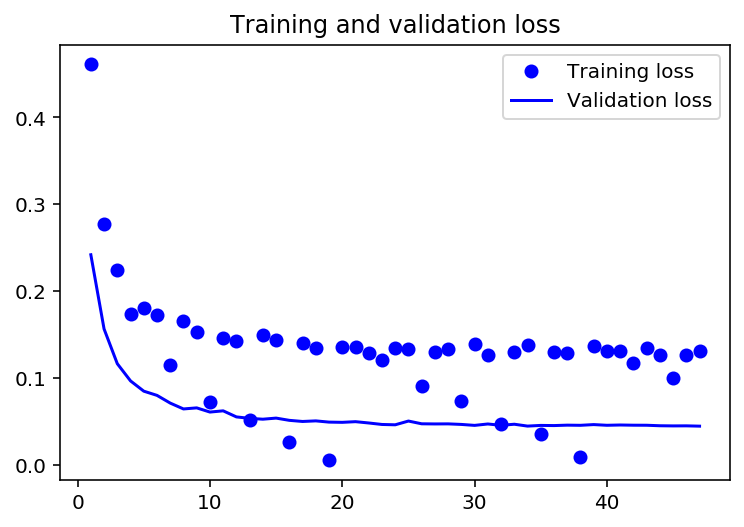

In [21]:
model_indicators_resnet50 = model_indicators.copy()
help.plt_result(model_indicators_resnet50)

In [23]:
loadmodel_resnet50 = help.load_checkpoint(help.resnet50_checkpoint_path,'resnet50')
help.check_logloss_on_test(loadmodel_resnet50,help.datatest_dataloaders,criterion,help.device)

Test Loss:0.042... Test Accuracy:0.987


Resnet50模型在测试集上的Test loss达到0.042，满足逾期低于0.06，随后将用该模型测试kaggle测试集，提交结果看最终得分

## 使用预训练模型Inception v3作为基础模型进行训练

In [6]:
model_inception_v3 = models.inception_v3(pretrained = True)
model_inception_v3.aux_logits = False
model_inception_v3.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [7]:
for param in model_inception_v3.parameters():
    param.requires_grad = False
    
#分类器在resnet50基础上修改，输出output_size为种类2
inception_v3_fc = nn.Sequential(
                           nn.Linear(2048, 2),
                           nn.LogSoftmax(dim=1))
model_inception_v3.fc = inception_v3_fc
print(model_inception_v3.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=2, bias=True)
  (1): LogSoftmax()
)


inception_v3模型输入图片大小默认为299*299，所以需要单独处理数据集

In [8]:
train_transforms_299 = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(299),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
valid_transforms_299 = transforms.Compose([transforms.Resize(350),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
# Load the datasets with ImageFolder
train_datasets_299 = datasets.ImageFolder(help.train_dir,transform=train_transforms_299)
valid_datasets_299 = datasets.ImageFolder(help.val_dir,transform=valid_transforms_299)
datatest_datasets_299 = datasets.ImageFolder(help.datatest_dir,transform=valid_transforms_299)



# Using the image datasets and the trainforms, define the dataloaders
train_dataloaders_299 = torch.utils.data.DataLoader(train_datasets_299,batch_size=help.TRAIN_BATCH_SIZE,shuffle=True)
valid_dataloaders_299 = torch.utils.data.DataLoader(valid_datasets_299,batch_size=help.VAL_BATCH_SIZE)
datatest_dataloaders_299 = torch.utils.data.DataLoader(datatest_datasets_299,batch_size=help.VAL_BATCH_SIZE)

In [9]:
model_indicators.drop(model_indicators.index,inplace=True)
start = time.time()
do_deep_learning(model_inception_v3,'inception_v3',train_dataloaders_299,valid_dataloaders_299,EPOCHS,help.print_every,criterion,help.inception_v3_checkpoint_path,help.device)
end = time.time()
runing_time = end - start
print('Inception_v3 Training time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

Epochs: 1/15... Trianing Loss:0.335... Val Loss:0.144... Val Accuracy:0.952
Epochs: 1/15... Trianing Loss:0.216... Val Loss:0.094... Val Accuracy:0.977
Epochs: 1/15... Trianing Loss:0.203... Val Loss:0.077... Val Accuracy:0.981
Epochs: 2/15... Trianing Loss:0.160... Val Loss:0.072... Val Accuracy:0.978
Epochs: 2/15... Trianing Loss:0.194... Val Loss:0.075... Val Accuracy:0.975
Epochs: 2/15... Trianing Loss:0.186... Val Loss:0.064... Val Accuracy:0.980
Epochs: 3/15... Trianing Loss:0.132... Val Loss:0.061... Val Accuracy:0.981
Epochs: 3/15... Trianing Loss:0.189... Val Loss:0.065... Val Accuracy:0.980
Epochs: 3/15... Trianing Loss:0.197... Val Loss:0.063... Val Accuracy:0.979
Epochs: 4/15... Trianing Loss:0.100... Val Loss:0.056... Val Accuracy:0.981
Epochs: 4/15... Trianing Loss:0.186... Val Loss:0.058... Val Accuracy:0.978
Epochs: 4/15... Trianing Loss:0.200... Val Loss:0.058... Val Accuracy:0.981
Epochs: 5/15... Trianing Loss:0.071... Val Loss:0.059... Val Accuracy:0.979
Epochs: 5/15

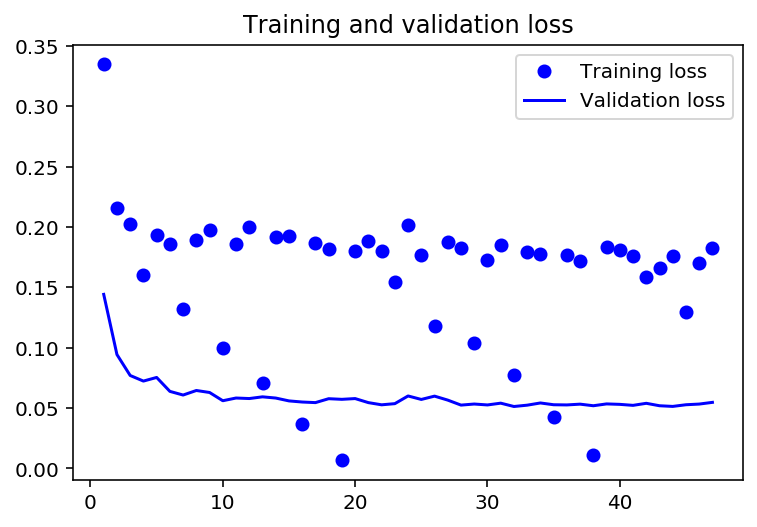

In [10]:
model_indicators_inception_v3= model_indicators.copy()
help.plt_result(model_indicators_inception_v3)

In [11]:
loadmodel_inception_v3 = help.load_checkpoint(help.inception_v3_checkpoint_path,'inception_v3')
help.check_logloss_on_test(loadmodel_inception_v3,datatest_dataloaders_299,criterion,help.device)

Test Loss:0.050... Test Accuracy:0.985


Inception v3模型在测试集上的Test loss达到0.057，满足逾期低于0.06，随后将用该模型测试kaggle测试集，提交结果看最终得分

## 在kaggle给的测试集上测试，生成结果文件

### 使用训练好的VGG16模型进行最终测试

In [11]:
start = time.time()
help.save_result(help.test_dataloaders,loadmodel_vgg16,help.device,help.optimalmodel_vgg16)
end = time.time()
runing_time = end - start
print('Test time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

0 pictures have been predicted
----------------------------------------
1250 pictures have been predicted
----------------------------------------
2500 pictures have been predicted
----------------------------------------
3750 pictures have been predicted
----------------------------------------
5000 pictures have been predicted
----------------------------------------
6250 pictures have been predicted
----------------------------------------
7500 pictures have been predicted
----------------------------------------
8750 pictures have been predicted
----------------------------------------
10000 pictures have been predicted
----------------------------------------
11250 pictures have been predicted
----------------------------------------
Test time is 3m 33s
Test time is 3m 33s


将训练好的$\color{blue}{Vgg16}$模型生成的结果提交到kaggle，得分为$\color{blue}{0.05783}$,已经满足项目预期

### 使用训练好的Densenet121模型进行最终测试

In [17]:
start = time.time()
help.save_result(help.test_dataloaders,loadmodel_densenet121,help.device,help.optimalmodel_densenet121)
end = time.time()
runing_time = end - start
print('Test time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

0 pictures have been predicted
----------------------------------------
1250 pictures have been predicted
----------------------------------------
2500 pictures have been predicted
----------------------------------------
3750 pictures have been predicted
----------------------------------------
5000 pictures have been predicted
----------------------------------------
6250 pictures have been predicted
----------------------------------------
7500 pictures have been predicted
----------------------------------------
8750 pictures have been predicted
----------------------------------------
10000 pictures have been predicted
----------------------------------------
11250 pictures have been predicted
----------------------------------------
Test time is 6m 31s
Test time is 6m 31s


将训练好的$\color{blue}{Densenet121}$模型生成的结果提交到kaggle，得分为$\color{blue}{0.06845}$，与期望值小于0.6差距有差距

### 使用训练好的Resnet50模型进行最终测试

In [24]:
help.save_result(help.test_dataloaders,loadmodel_resnet50,help.device,help.optimalmodel_resnet50)


0 pictures have been predicted
----------------------------------------
1250 pictures have been predicted
----------------------------------------
2500 pictures have been predicted
----------------------------------------
3750 pictures have been predicted
----------------------------------------
5000 pictures have been predicted
----------------------------------------
6250 pictures have been predicted
----------------------------------------
7500 pictures have been predicted
----------------------------------------
8750 pictures have been predicted
----------------------------------------
10000 pictures have been predicted
----------------------------------------
11250 pictures have been predicted
----------------------------------------
Test time is 3m 38s


将训练好的$\color{blue}{Resnet50}$模型生成的结果提交到kaggle，得分为$\color{blue}{0.06008}$，与期望值小于0.6差距有差距

### 使用训练好的Inception v3模型进行最终测试

In [12]:
test_datasets_299 = help.TestDataset(help.id_label_path,help.test_dir,transforms=valid_transforms_299)
test_dataloaders_299 = DataLoader(test_datasets_299)

In [13]:

help.save_result(test_dataloaders_299,loadmodel_inception_v3,help.device,help.optimalmodel_inception_v3)


0 pictures have been predicted
----------------------------------------
1250 pictures have been predicted
----------------------------------------
2500 pictures have been predicted
----------------------------------------
3750 pictures have been predicted
----------------------------------------
5000 pictures have been predicted
----------------------------------------
6250 pictures have been predicted
----------------------------------------
7500 pictures have been predicted
----------------------------------------
8750 pictures have been predicted
----------------------------------------
10000 pictures have been predicted
----------------------------------------
11250 pictures have been predicted
----------------------------------------
Test time is 6m 48s


将训练好的 $\color{blue}{Inception v3}$ 模型生成的结果提交到kaggle，得分为 $\color{blue}{0.07339}$ ，与期望值小于0.6差距有差距


多模型结果组合方法有:

* 结果多数表决

* 结果直接平均

* 结果加权平均

此题由于需要提交的是各图像狗狗的概率，故采用后两种方法较为合适

$\color{red}{**小技巧**:}$

**$\color{red}{本项目的测试指标是LogLoss,对于预测的正样本,0.995和1差别不大,但对于预测负样本0和0005却相差甚远;}$**

**$\color{red}{因此对于最终提交结果可使用np.clip将概率值限制在[0.005,0.995之间,可以一定幅度的改善Score]}$**

将训练好的$\color{blue}{Densenet121}$、$\color{blue}{Inception v3}$、$\color{blue}{Resnet50}$以及$\color{blue}{VGG16}$模型生成的结果组合求平均，在此提交到kaggle得分为$\color{red}{0.05826}$

将训练好的$\color{blue}{Densenet121}$、$\color{blue}{Inception v3}$、$\color{blue}{Resnet50}$以及$\color{blue}{VGG16}$模型生成的结果按比例组合(Resnet50\*0.55 + Densenet121\*0.2 + Inception_v3\*0.15 + Vgg16*0.1)，在此提交到kaggle得分为$\color{red}{0.05915}$

## 对训练过的模型分别进行抽样预测

[10181 11433 11178  2242 12431  5455  6919  5541 12415 11790]


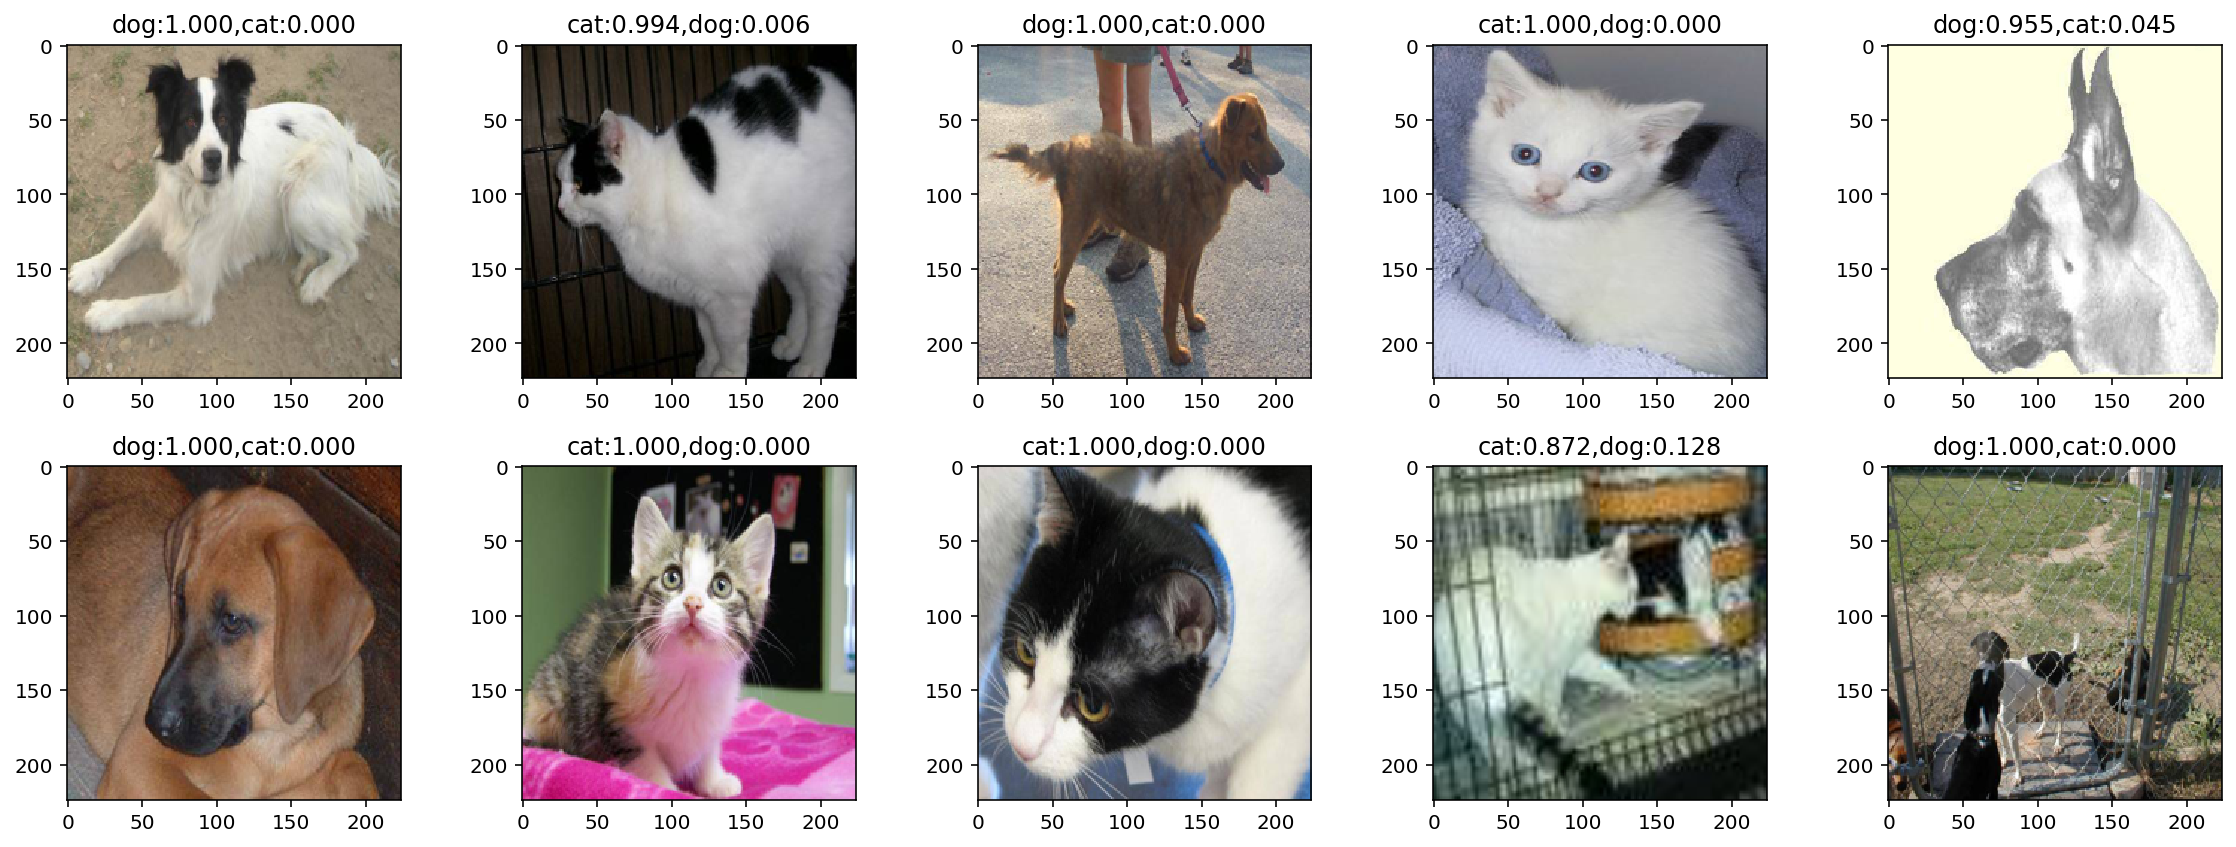

In [36]:
help.display_samples(loadmodel_vgg16,224)

[ 6842  1706  4249  8525  6118 12231   319 11831  2522 11767]


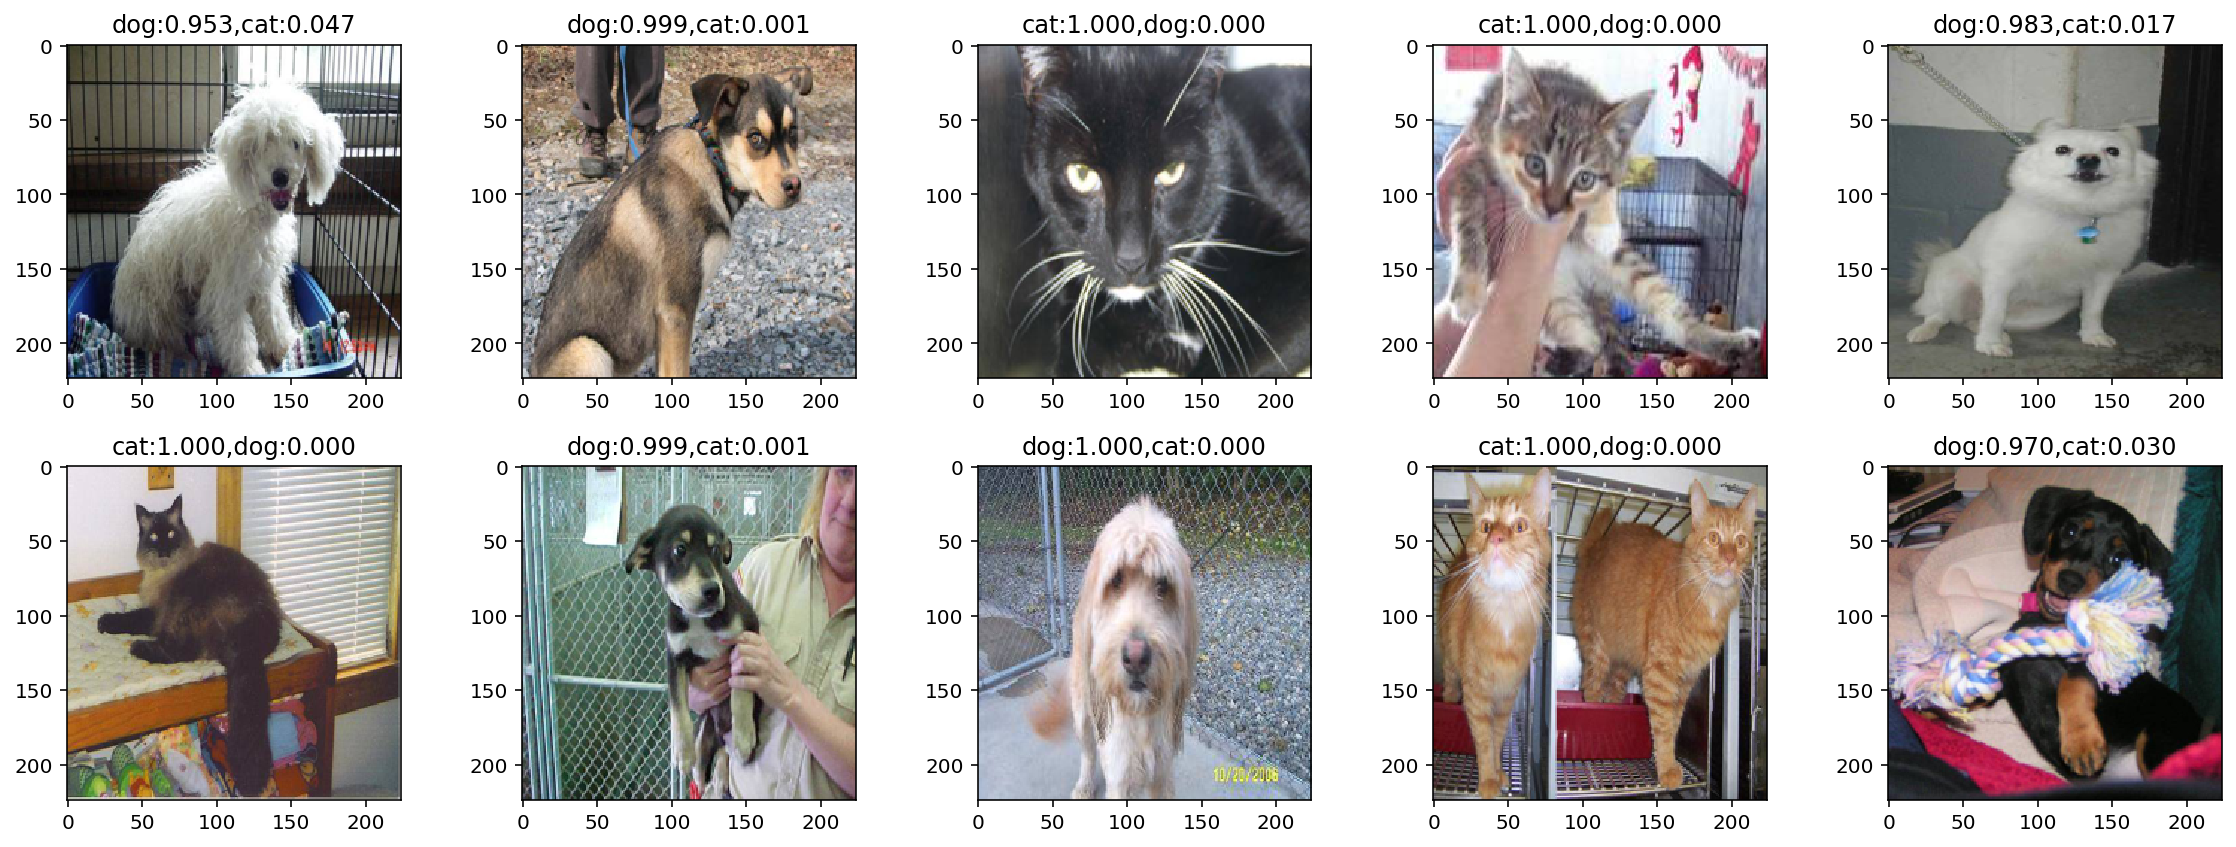

In [37]:
help.display_samples(loadmodel_densenet121,224)

[11131  2522 10682  7070 12460  5917  5651 12309  4960  9956]


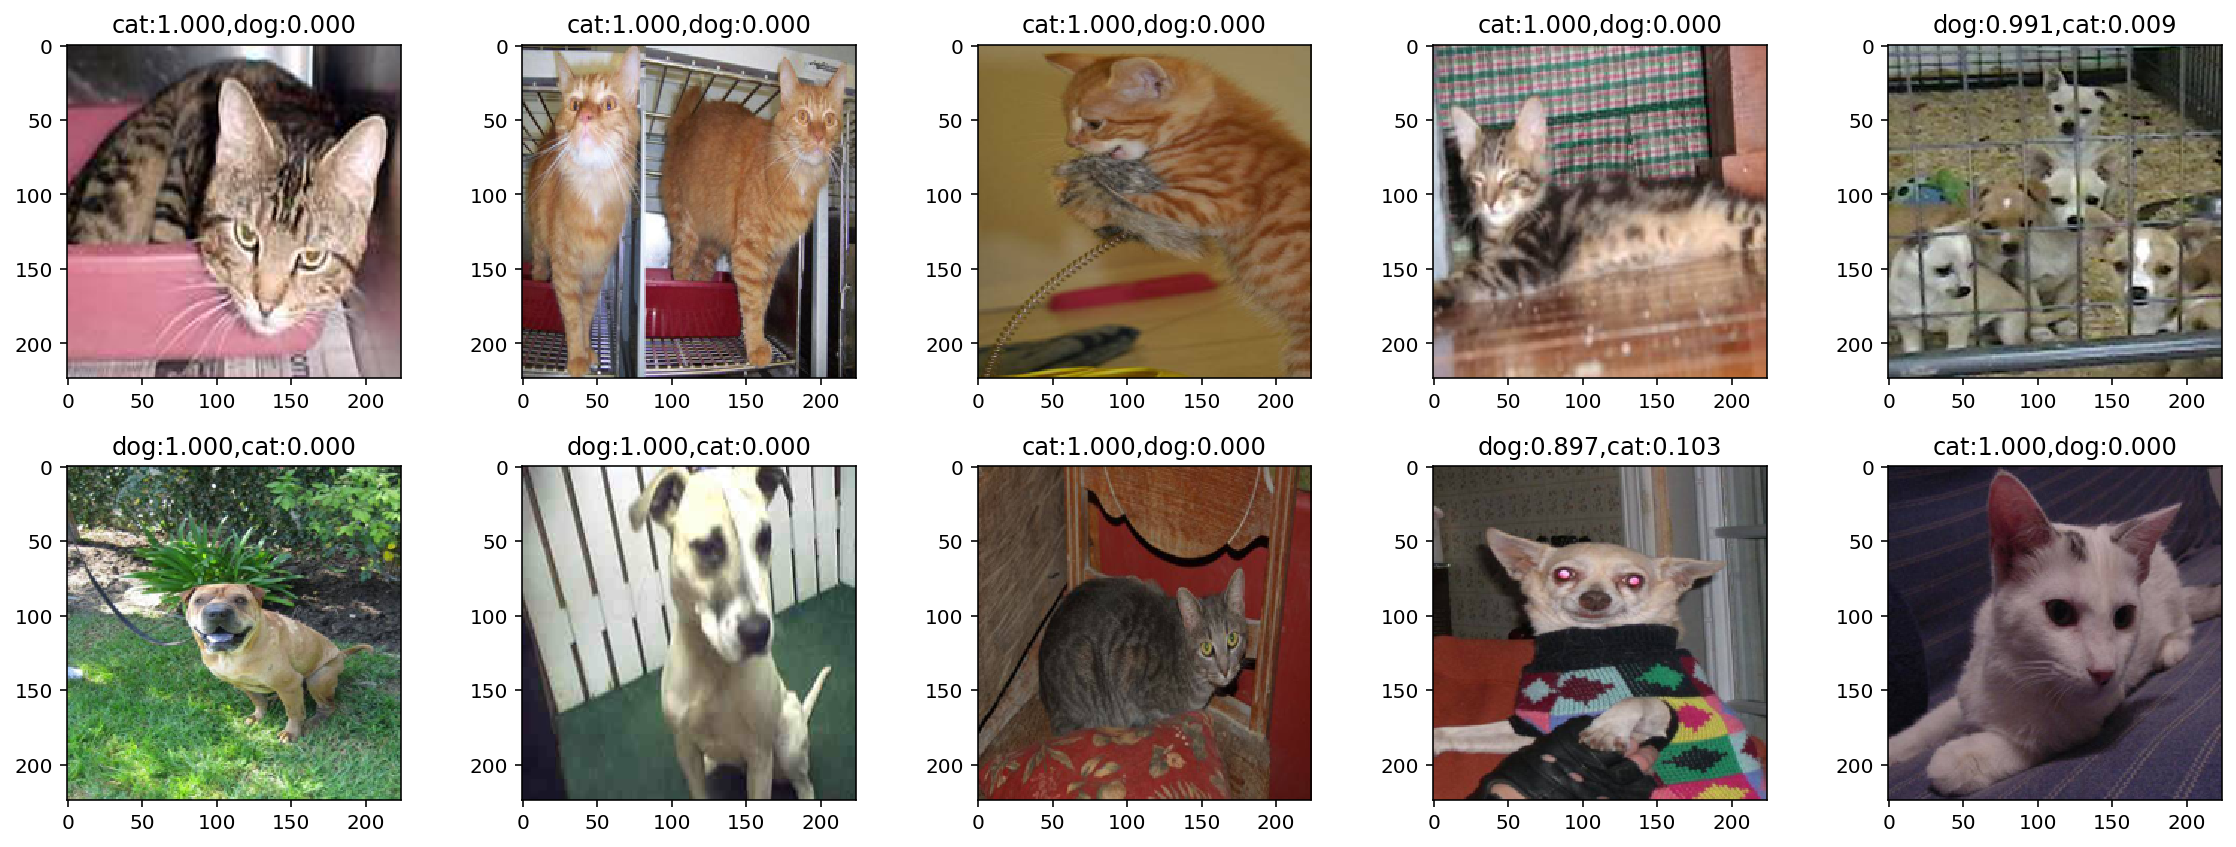

In [38]:
help.display_samples(loadmodel_resnet50,224)

[ 4256  3418  6543   256  7246  5775  5665  1625 11062  4070]


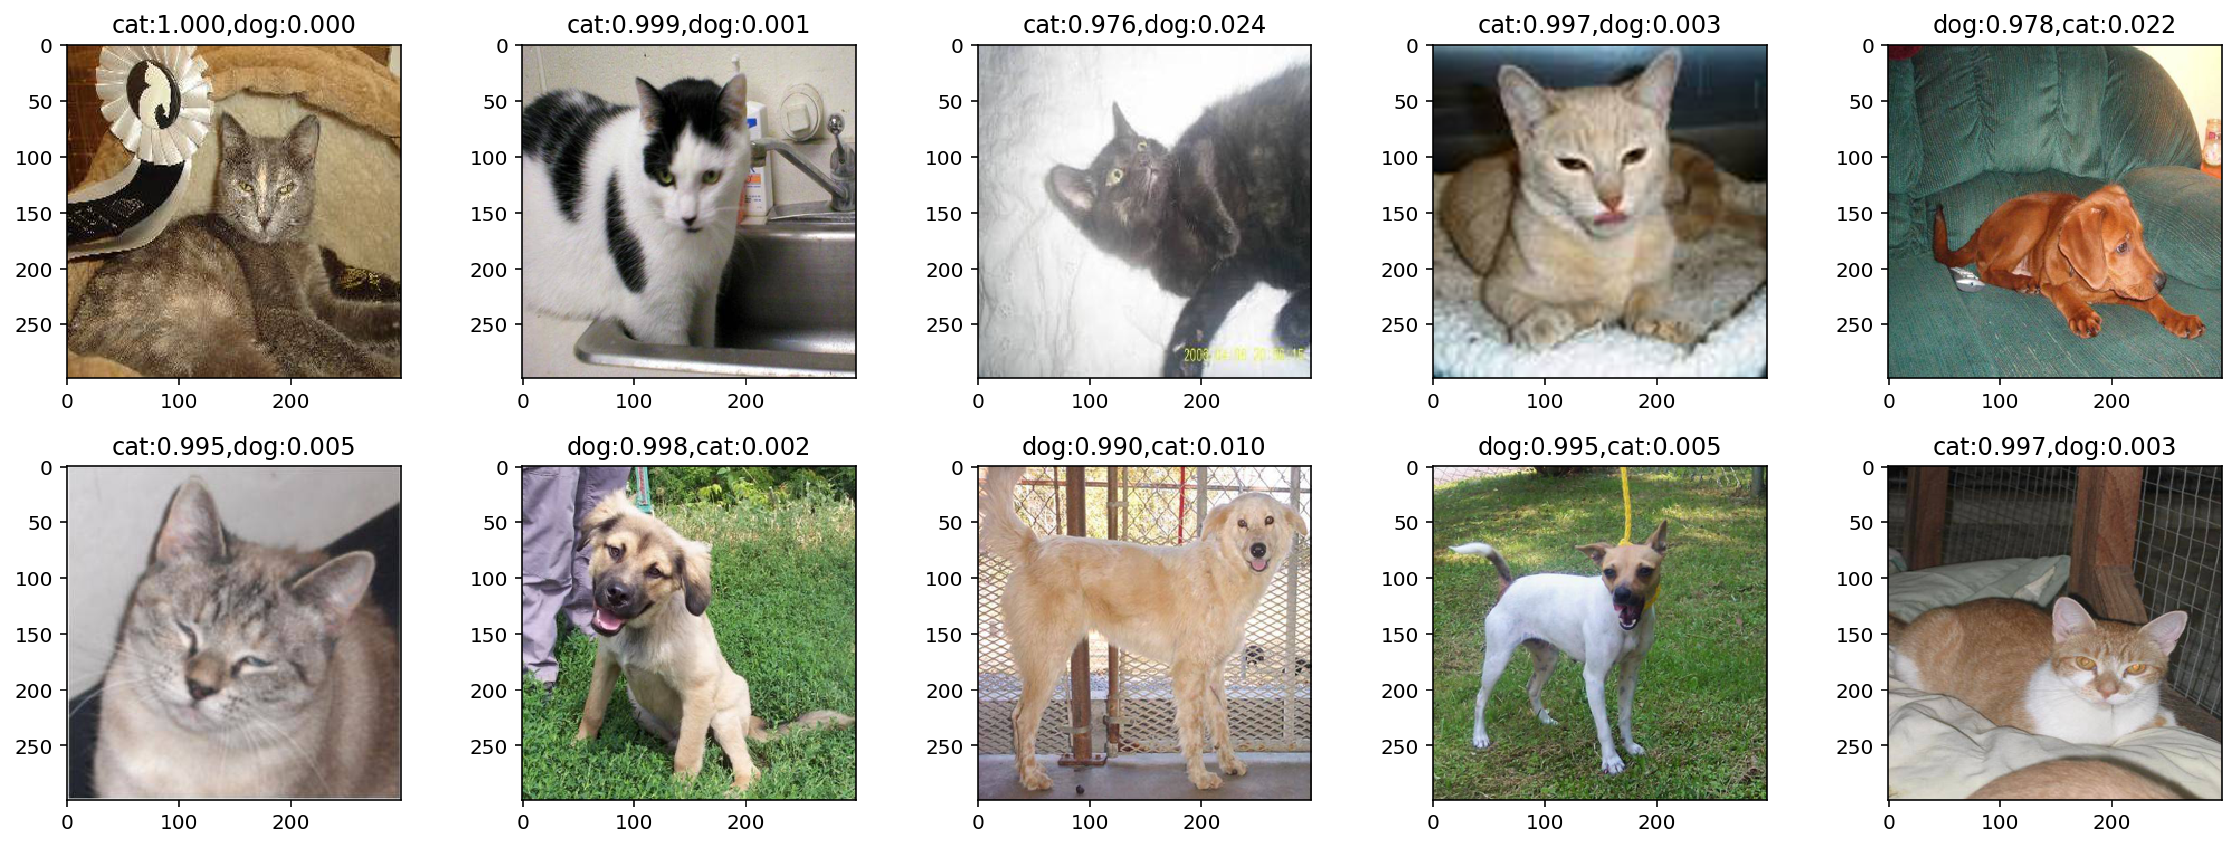

In [25]:
help.display_samples(loadmodel_inception_v3,299)